Library Imports

In [1]:
import matplotlib
import statsmodels.api as sm
import numpy as np
import pandas as pd
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper
from sklearn.metrics import explained_variance_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# Data Entry and Pre-processing

Promos File Input + Generation of Dummy Variables

In [2]:
promos=pd.read_csv('data/promos.csv')
promos['promo_type'] = pd.Categorical(promos.promo_type)
promos['promo_start_dt'] = pd.to_datetime(promos['promo_start_dt'])
promos['promo_end_dt'] = pd.to_datetime(promos['promo_end_dt'])
promos = pd.get_dummies(promos, columns=['promo_type'])

Transactions File Input + Filling missing values

In [3]:
transactions=pd.read_csv('data/transactions.csv')
transactions['history_date'] = pd.to_datetime(transactions['history_date'])
transactions['sales'].fillna(0, inplace=True)

Transaction Aggregation to week level 

In [4]:
transactions = transactions.groupby(['item_id','category_id', pd.Grouper(key='history_date', freq='W')]).agg({'inventory':'mean', 'sales':'sum','price':'mean'}).reset_index()

Data Merging 

In [5]:
data = pd.merge(promos, transactions, on='item_id')

for i in range (len(data)):
    if data['history_date'][i]<data['promo_start_dt'][i] or data['history_date'][i] > data['promo_end_dt'][i]:
        data['promo_type_PROMO_A'][i]=0
        data['promo_type_PROMO_B'][i]=0
        data['promo_type_PROMO_C'][i]=0
        

Cleaning and Extracting prepared data to file for easier continuation of work

In [6]:
data.drop(['promo_start_dt','promo_end_dt'], axis=1) 
data['units']=data['sales']//data['price']

data.to_csv('data/cognira_data.csv', sep= ';', encoding = 'utf-8')
            

Preparing Data for the modelling phase

In [7]:
df_units=data.groupby(["category_id"]).sum().sort_values("units", ascending=True)
data['history_date'] = pd.to_datetime(data['history_date'])
# data['promo_start_dt'] = pd.to_datetime(data['promo_start_dt'])
# data['promo_end_dt'] = pd.to_datetime(data['promo_end_dt'])
data['promo_type_PROMO_A'] = pd.Categorical(data.promo_type_PROMO_A)
data['promo_type_PROMO_B'] = pd.Categorical(data.promo_type_PROMO_B)
data['promo_type_PROMO_C'] = pd.Categorical(data.promo_type_PROMO_C)
data['category_id'] = pd.Categorical(data.category_id)


# Panel data modeling

In [8]:
year = pd.Categorical(data.history_date)
dataTemp = data.set_index(['category_id', 'history_date'])
dataTemp['year'] = year

Panel Data  Model with complete Data  

In [9]:
exog_vars = ['promo_type_PROMO_A', 'promo_type_PROMO_B','promo_type_PROMO_C','inventory']
exog = sm.add_constant(dataTemp[exog_vars])
mod = PanelOLS(dataTemp.units, exog)
re_res = mod.fit()
print(re_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  units   R-squared:                        0.0055
Estimator:                   PanelOLS   R-squared (Between):             -0.0075
No. Observations:                9511   R-squared (Within):               0.0057
Date:                Sat, Dec 21 2019   R-squared (Overall):              0.0055
Time:                        01:01:33   Log-likelihood                -2.976e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      13.074
Entities:                           6   P-value                           0.0000
Avg Obs:                       1585.2   Distribution:                  F(4,9506)
Min Obs:                       1294.0                                           
Max Obs:                       1820.0   F-statistic (robust):             13.074
                            

This model is a simple linear model that provides us with bad results, this is possibl;y exacerbated because of the
large amount of missing entries which have been set to 0 Hencem we re-excute the  model
with 0s removed from the sales data

In [10]:
## deleting rows where sales equals to 0
data1=dataTemp[dataTemp['sales']!=0]

exog_vars = ['promo_type_PROMO_A', 'promo_type_PROMO_B','promo_type_PROMO_C','inventory']
exog = sm.add_constant(data1[exog_vars])
mod = PanelOLS(data1.units, exog)
re_res = mod.fit()
print(re_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  units   R-squared:                        0.0104
Estimator:                   PanelOLS   R-squared (Between):              0.0084
No. Observations:                3326   R-squared (Within):               0.0108
Date:                Sat, Dec 21 2019   R-squared (Overall):              0.0104
Time:                        01:01:33   Log-likelihood                -1.097e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.7224
Entities:                           6   P-value                           0.0000
Avg Obs:                       554.33   Distribution:                  F(4,3321)
Min Obs:                       438.00                                           
Max Obs:                       638.00   F-statistic (robust):             8.7224
                            

As we can see from observing the R-squared and other properties, this still provides us with a very bad model.
This is especially due to the model trying to generalize one linear model to all of the duration

Since this model did not work, we would like to visualize the data to get a better understanding of the 
problem and correlation between the different features

# Visualisation for Sales1 & promos effect

In [11]:
#reset the index to simplify the manipulation
data.reset_index()
# sales for type1
sales1 = data[data.category_id == 1].loc[:, ['history_date', 'sales']]

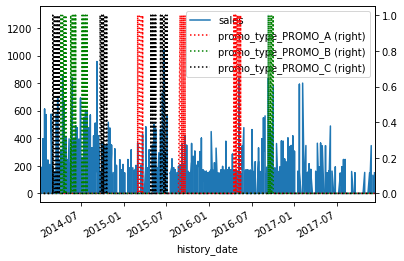

In [12]:
cat1=sales1[sales1['sales']!=0]
y = sales1.set_index(['history_date'])
y.head(5)



fig, ax = plt.subplots()

y.plot(ax=ax)

catA=data[data.category_id == 1].loc[:, ['history_date', 'promo_type_PROMO_A']]
catA['promo_type_PROMO_A']=pd.to_numeric(catA.promo_type_PROMO_A)
yp=catA.set_index(['history_date'])
yp.plot(style= 'r:', ax=ax, secondary_y = True)


catB=data[data.category_id == 1].loc[:, ['history_date', 'promo_type_PROMO_B']]
catB['promo_type_PROMO_B']=pd.to_numeric(catB.promo_type_PROMO_B)
yp=catB.set_index(['history_date'])
yp.plot(style= 'g:', ax=ax, secondary_y = True)

catC=data[data.category_id == 1].loc[:, ['history_date', 'promo_type_PROMO_C']]
catC['promo_type_PROMO_C']=pd.to_numeric(catC.promo_type_PROMO_C)
yp=catC.set_index(['history_date'])
yp.plot(style= 'k:', ax=ax, secondary_y = True)

plt.show()

As we can visually extrapolate, there's a certain seasonality in the sales closer to the end of the year
and there's also a possible effect  of both the promos A and B on sales of the products in this category.
As a result a time series analysis seems a good approach to analyze this model

# Time series Analysis

Model analysis with all sales values

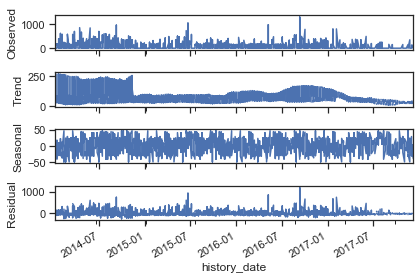

<Figure size 1440x1008 with 0 Axes>

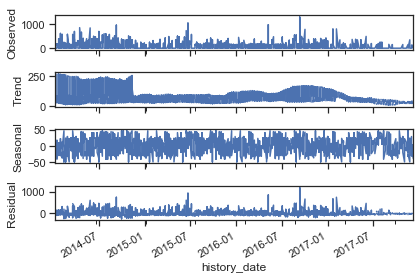

In [13]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (20, 14))

decomposition = seasonal_decompose(y, model = 'additive', freq = 48)
decomposition.plot()

Model analysis with non null sales values

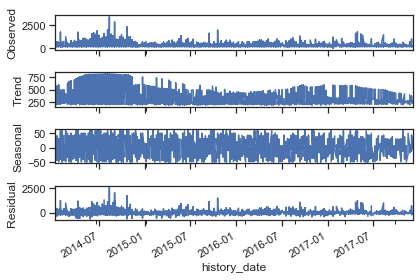

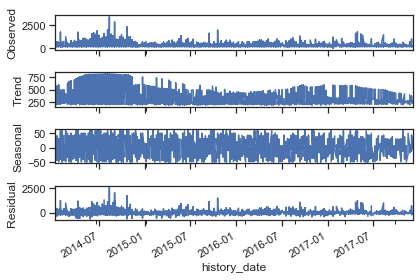

In [14]:
x=data[data['sales']!=0]
x1= x.loc[:, ['history_date', 'sales']]
y = x1.set_index(['history_date'])
decomposition_a = seasonal_decompose(y, model = 'additive', freq = 52)
decomposition_a.plot()

for both the model that include and that ignore the null sales values, it's clear that there's a certain seasonality
and trend in the sales, hence the complexity of the model and the incapabablity of a linear model of giving
us good results

# Model ARIMA
An ARIMA model is a class of statistical models for analyzing and forecasting time series data.
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:
p: The number of lag observations included in the model, also called the lag order. Extraced from the ACF
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average. Extraced from the PACF

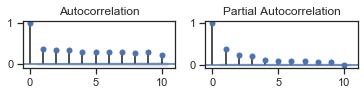

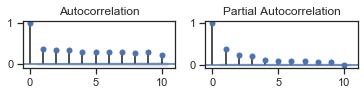

In [15]:
# acf and pacf for A

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.subplot(421); plot_acf(y, lags = 10, ax = plt.gca())
plt.subplot(422); plot_pacf(y, lags = 10, ax = plt.gca())

p is the first value for the ACF cross 0.2 value on the Y axis ( the confidence interval)
q is the first value for the PACF cross 0.2 value on the Y axis
Visually we can see that q is 5 and that p is 3
d is 0 in our case as the data is not differenced

Training the ARIMA Mode:

In [16]:

print(len(y))
print(len(y)*0.8)
#### 80/20 division
train = np.log(y[0:2660])
test = np.log(y[2661:])


from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train=train.fillna(method='ffill')
model_ar=ARIMA(train, order=(5,0,3))
model_ar_fit=model_ar.fit()

3326
2660.8


Visualizing the ARIMA Model:

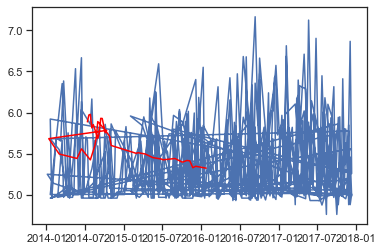

In [17]:
predictions=model_ar_fit.predict(start=45,end=80)
a= plt.plot(test),plt.plot(predictions,color='red')

As we can see, the results are still very unsatisfactory, hence we decided to try another model to better appraoch the problem

# XGBoost
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
It is a commonly used machine learning algorithm

Data reading and preparation

In [18]:
base = pd.read_csv('data\cognira_data.csv',sep=';')
base.drop(['promo_start_dt','promo_end_dt'], axis='columns', inplace=True)
base['history_date'] = pd.to_datetime(base['history_date'])
base['year'] = base['history_date'].dt.year
base['month'] = base['history_date'].dt.month
base['day'] = base['history_date'].dt.day
base=base[base['sales']!=0]

Dataset split into testing and training sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(base[['item_id','day','inventory','month',
'price','promo_type_PROMO_A','promo_type_PROMO_B','promo_type_PROMO_C','year']], base[['sales']], 
test_size = 0.3,random_state = 42)

Training the model

In [20]:
model=XGBRegressor()

eval_set = [(X_train, y_train), (X_test, y_test)]

fit_params={'eval_metric':'rmse',
            'eval_set':eval_set,
            'early_stopping_rounds':10,
            'verbose':True,
            #'sample_weight':sample_weight
           }
finalmodel = model.fit(X_train,y_train, **fit_params)


[01:02:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:349.532	validation_1-rmse:341.514
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:325.921	validation_1-rmse:318.226
[2]	validation_0-rmse:305.426	validation_1-rmse:298.162
[3]	validation_0-rmse:287.633	validation_1-rmse:280.726
[4]	validation_0-rmse:271.985	validation_1-rmse:265.991
[5]	validation_0-rmse:258.688	validation_1-rmse:253.748
[6]	validation_0-rmse:247.183	validation_1-rmse:243.142
[7]	validation_0-rmse:237.166	validation_1-rmse:234.198
[8]	validation_0-rmse:228.826	validation_1-rmse:226.01
[9]	validation_0-rmse:221.656	validation_1-rmse:218.9
[10]	validation_0-rmse:215.39	validation_1-rmse:212.867
[11]	validation_0-rmse:209.725	validation_1-rmse:207.798
[12]	va

Predictions and evaluations of model

In [21]:
output1 = finalmodel.predict(data=X_test)
final_df = pd.DataFrame()
final_df["item-id"] = X_test.item_id.values
final_df["Prediction"] = output1
final_df.to_csv("Output_XGB.csv")
# evaluate predictions
print(explained_variance_score(y_test,output1,multioutput='raw_values'))
print(explained_variance_score(y_test,output1,multioutput='variance_weighted'))
rmse = np.sqrt(mean_squared_error(y_test, output1))
print("RMSE: %f" % (rmse))

[0.33912579]
0.339125792533863
RMSE: 180.310379


While still not great, these statistical properties are more acceptable than those obtained in
previous models

Visualization of importance of features in Model:

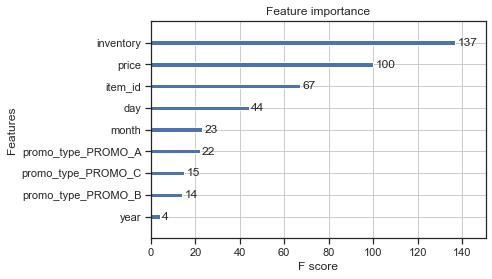

In [22]:
xgb.plot_importance(finalmodel)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

As a result, we can conclude that a product's availability and price, as well as the promos available amd the day/month 
have a significant effects on its sales

# Further Enhancing the model

Further Sales decomposition and analysis:

In [23]:
sales = pd.DataFrame(base.groupby(['history_date','category_id']).sum()['sales']).unstack()
sales = sales.resample('7D',label='left').sum()
sales.sort_index(inplace = True)

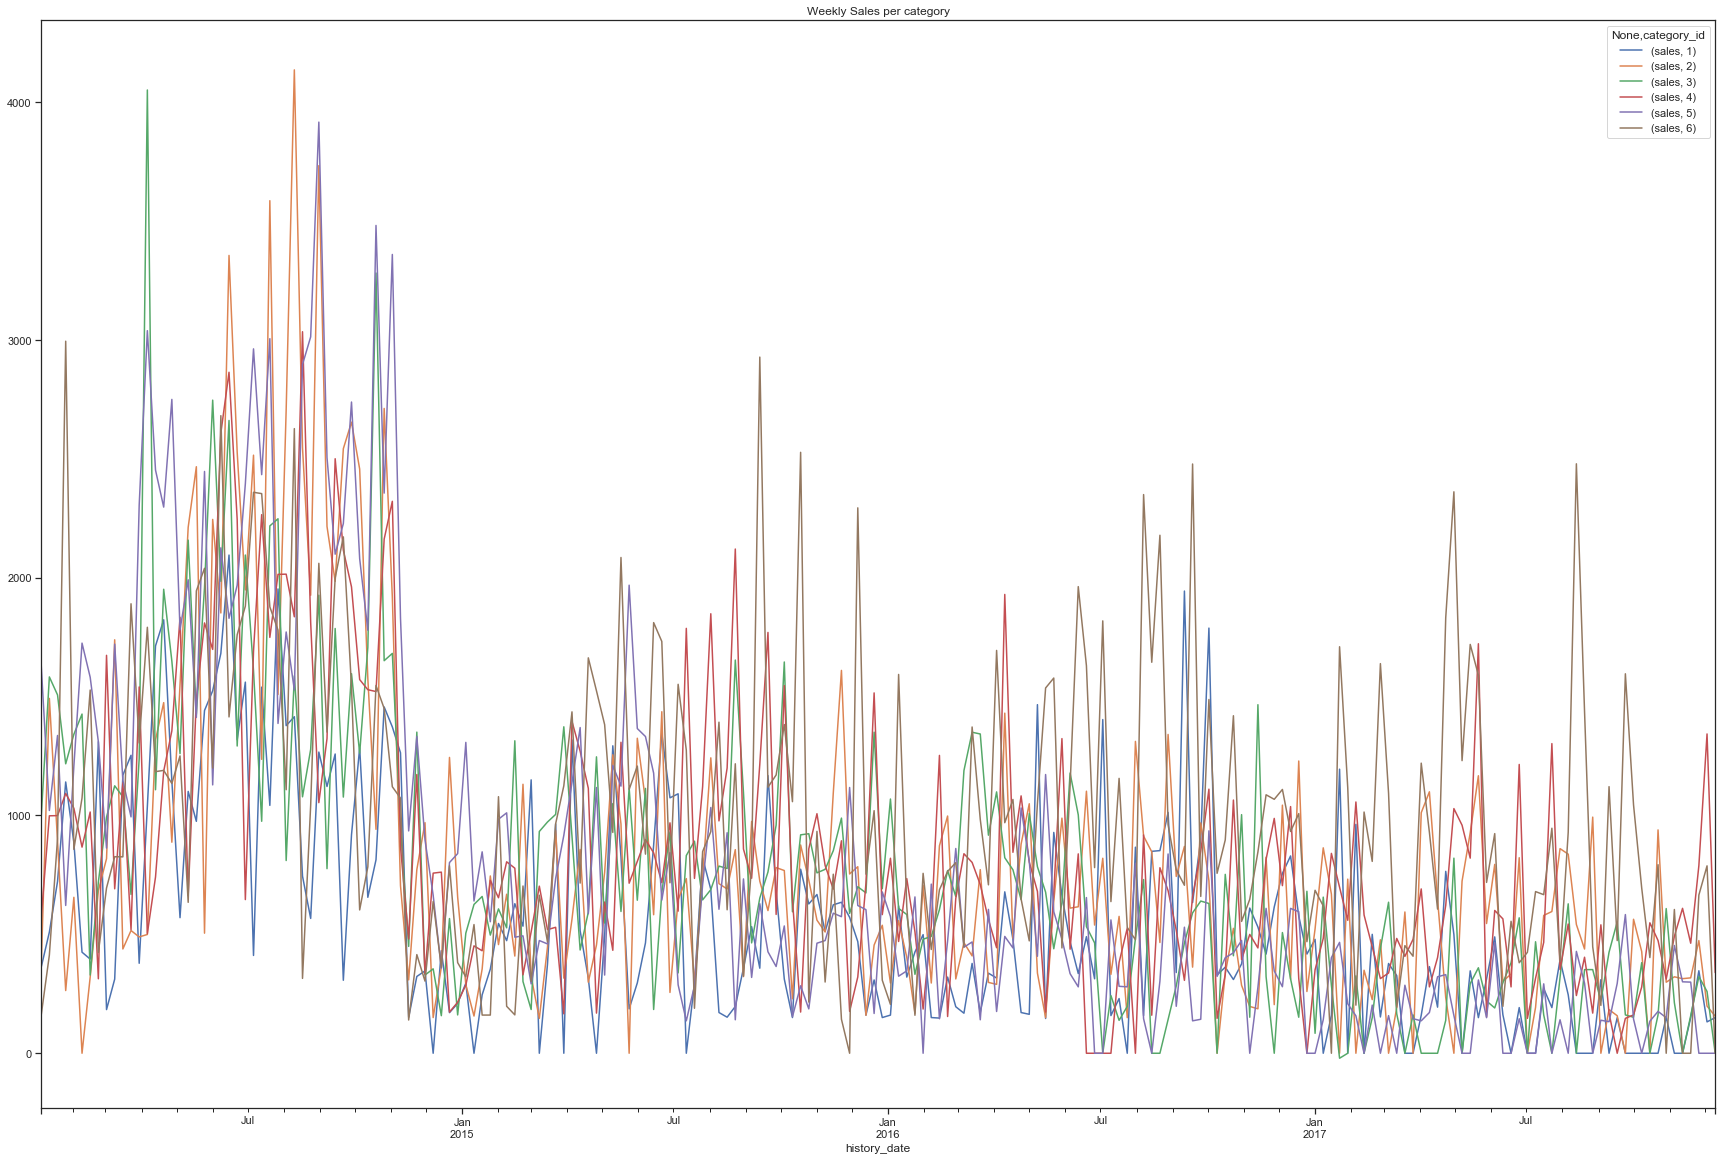

In [24]:
sales.plot(figsize=(30,20), title='Weekly Sales per category')
plt.show()

As visible through this graph, the data is stil too complex to visually analyse

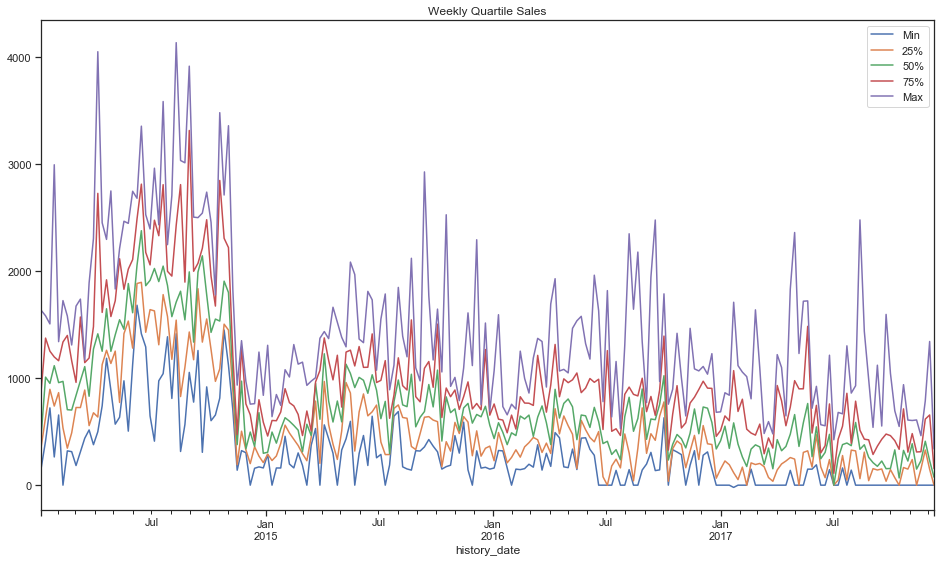

In [25]:
sales_qtr = pd.DataFrame(sales.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
sales_qtr.sort_index(inplace = True)
sales_qtr.columns = ['Min','25%','50%','75%','Max']
sales_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

Even with the quarterly division of sales, the data is still a bit complex to analyse visually

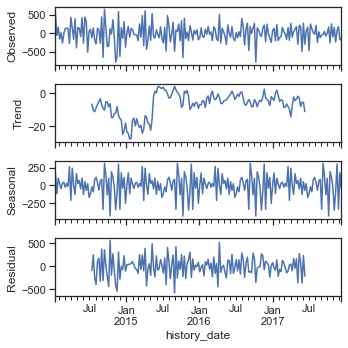

In [26]:
seasonal = seasonal_decompose(pd.DataFrame(sales_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

Analysing the 50% quartile of sales, we can see an even clearer pattern of seasonality and trend
As a result, it can be condluded that the data still has more relationships  between features that can be extracted

Configuring XGB for more training loops will give us enhanced precision, reflective of the bigger amount of information 
contained in the model that wasn't explored by the previous version.

In [35]:
def xboost(X1, y1, X):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(X1, label=y1, feature_names=list(X1.columns))
    dtest = xgb.DMatrix(X, feature_names=list(X.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 100

    bst = xgb.train(params, dtrain, num_rounds)
    
    return bst.predict(dtest)

In [36]:
preds = xboost(X_train,y_train,X_test)



In [37]:
values = y_test.sales.values  # numpy array of values
matrix = np.concatenate([values])  # append to the final matrix


rmse = np.sqrt(mean_squared_error(matrix, preds))
print("RMSE: %f" % (rmse))


RMSE: 176.598574


As we can observe, we've obtined a relatively better RMSE that can be further enhanced by increasing the number 
of roundds given to the algorithm
